In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.nestcomparison import NestComparison
from pelenet.network import ReservoirNetwork

# Official modules
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()

In [3]:
# Get inputs
inp = []
inp.append(np.load('data/nest/left_top/input.npy')[0,0])
inp.append(np.load('data/nest/somewhere/input.npy'))

# Get weights
masks = []

exex = csr_matrix(np.load('data/nest/left_top/weights_ee.npy'))
exin = csr_matrix(np.load('data/nest/left_top/weights_ei.npy'))
inex = csr_matrix(np.load('data/nest/left_top/weights_ii.npy'))
inin = csr_matrix(np.load('data/nest/left_top/weights_ie.npy'))
masks.append({ 'exex': exex, 'inin': inin, 'inex': inex, 'exin': exin })

exex = csr_matrix(np.load('data/nest/somewhere/weights_ee.npy'))
exin = csr_matrix(np.load('data/nest/somewhere/weights_ei.npy'))
inex = csr_matrix(np.load('data/nest/somewhere/weights_ii.npy'))
inin = csr_matrix(np.load('data/nest/somewhere/weights_ie.npy'))
masks.append({ 'exex': exex, 'inin': inin, 'inex': inex, 'exin': exin })

In [4]:
def simLoihi(inp, ma):
    # Init experiment
    exp = NestComparison()

    # Build network
    exp.net = ReservoirNetwork(exp.p)
    
    # Define mask
    exp.net.initialMasks.exex = ma['exex']
    exp.net.initialMasks.exin = ma['exin']
    exp.net.initialMasks.inex = ma['inex']
    exp.net.initialMasks.inin = ma['inin']

    # Set weights
    exp.setSparseWeightMatrix()

    # Connect
    exp.net.connectReservoir()

    # Add patch input
    exp.net.addRepeatedPatchGenerator(idc = inp-1)

    # Build the network structure
    exp.net.build()

    # Get and print spectral radius
    utils.getSpectralRadius(exp.net.initialWeights)

    # Run network
    exp.run()
    
    return exp

INFO:DRV:  Connecting to 127.0.0.1:41875
INFO:DRV:      Host server up..............Done 0.58s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349428.0673892
Include dir is : /home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349428.0673892/initnetwork_0_0.c
gcc -Wall -I/home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /home/seq/.local/share/virtualenvs/seq-r0_WvjR

INFO:DRV:      Compiling Embedded snips....Done 2.57s
INFO:DRV:      Encoding axons/synapses.....Done 14.72s
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349428.0673892/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349428.0673892/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.56s
INFO:DRV:      Encoding probes.............Done 3.89ms
INFO:DRV:      Configuring registers.......Done 14.03s
INFO:DRV:      Transferring probes.........Done 0.02s
INFO:DRV:      Transferring spikes.........Done 0.02s
INFO:HST:  chip=1 cpu=0 Transfered values 20, 535, 30 
INFO:HST:  chip=0 cpu=0 Transfered values 

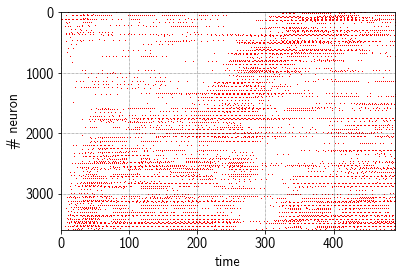

In [5]:
exp1 = simLoihi(inp[0], masks[0])
exp1.net.plot.reservoirSpikeTrain(fr=exp1.p.resetOffset, to=491+exp1.p.resetOffset)

INFO:DRV:  Connecting to 127.0.0.1:32903
INFO:DRV:      Host server up..............Done 0.07s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349633.0986488
Include dir is : /home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349633.0986488/initnetwork_0_0.c
gcc -Wall -I/home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -std=c99 -o /home/seq/.local/share/virtualenvs/seq-r0_WvjR

INFO:DRV:      Compiling Embedded snips....Done 0.66s
INFO:DRV:      Encoding axons/synapses.....Done 14.49s
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349633.0986488/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1586349633.0986488/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.52s
INFO:DRV:      Encoding probes.............Done 3.93ms
INFO:DRV:      Transferring probes.........Done 0.02s
INFO:DRV:      Configuring registers.......Done 14.18s
INFO:DRV:      Transferring spikes.........Done 3.37ms
INFO:HST:  chip=1 cpu=0 Transfered values 20, 535, 30 
INFO:HST:  chip=0 cpu=0 Transfered values

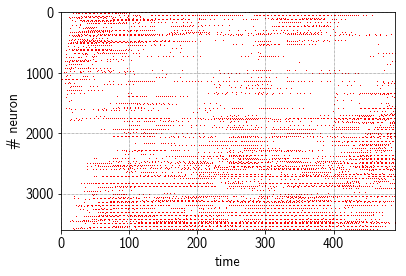

In [6]:
exp2 = simLoihi(inp[1], masks[1])
exp2.net.plot.reservoirSpikeTrain(fr=exp2.p.resetOffset, to=491+exp2.p.resetOffset)

In [7]:
exp.net.plot.plotDir

'/home/seq/05-reward/v0.x/datalog/2020-04-08_12-14-25/plots/'

In [8]:
matplotlib.rcParams.update({'font.size': 13})

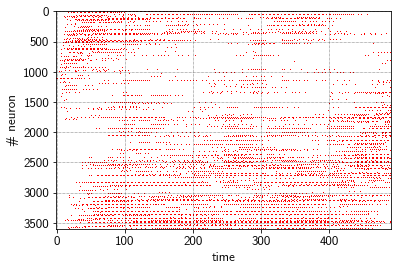

In [9]:
exp.net.plot.reservoirSpikeTrain(fr=exp.p.resetOffset, to=491+exp.p.resetOffset)

In [10]:
times = np.load('data/nest/times.npy')
lastIdc = np.where(times < 500)[0][-1]
nest = np.array([times[:lastIdc], np.load('data/nest/inds.npy')[:lastIdc]])

spikes = []

mi, ma = int(np.floor(np.min(nest[0]))), int(np.ceil(np.max(nest[0])))
for t in range(mi, ma):
    idcs = []
    for i in np.arange(0.0,1.0,0.1):
        idcs.extend(np.where(np.isclose(nest[0], t+i))[0])
    spkVec = np.zeros((exp.p.reservoirExSize))
    spkVec[nest[1, idcs].astype(int)-1] = 1
    spikes.append(spkVec)
spikes = np.array(spikes).T

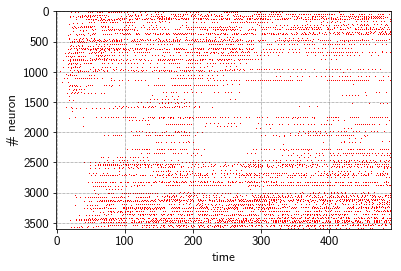

In [11]:
#plt.figure(figsize=(16, 10))
cmap = colors.ListedColormap(['white', 'red'])
#plt.title('NEST Reservoir spikes')
plt.xlabel('time')
plt.ylabel('# neuron')
plt.imshow(spikes, cmap=cmap, aspect='auto')
plt.savefig(exp.net.plot.plotDir + 'spikes_raster_nest.svg')

In [12]:
sl = exp.net.exSpikeTrains[:,exp.p.resetOffset:491+exp.p.resetOffset]  # spikes from loihi
sn = spikes # spikes from nest

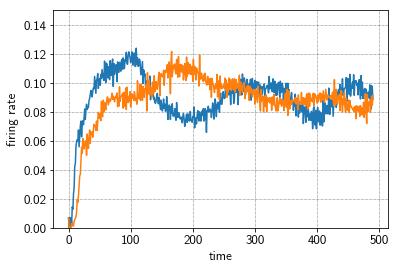

In [13]:
slm0 = np.mean(sl, axis=0)
snm0 = np.mean(sn, axis=0)

plt.plot(slm0)
#plt.title('Loihi')
plt.xlabel('time')
plt.ylabel('firing rate')
plt.ylim((0,0.15))
#plt.savefig(exp.net.plot.plotDir + 'firingrate_loihi.svg')
#p = plt.show()

plt.plot(snm0)
#plt.title('Nest')
plt.xlabel('time')
plt.ylabel('firing rate')
plt.ylim((0,0.15))
#plt.savefig(exp.net.plot.plotDir + 'firingrate_nest.svg')
p = plt.show()

(0, 0.12)

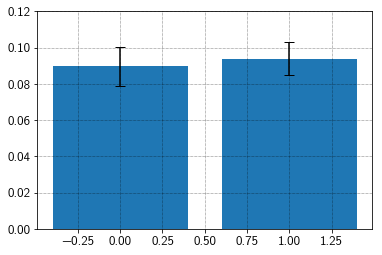

In [22]:
start = 100
vals = [np.mean(slm0[start:]), np.mean(snm0[start:])]
errs = [np.std(slm0[start:]), np.std(snm0[start:])]
plt.bar([0,1], vals, yerr=errs, ecolor='black', capsize=5)
plt.ylim(0,0.12)

In [23]:
scipy.stats.ttest_ind(slm0[start:], snm0[start:])

Ttest_indResult(statistic=-5.930242102127018, pvalue=4.542770205850879e-09)

In [16]:
scipy.stats.pearsonr(slm0[start:], snm0[start:])

(-0.41510776524684, 1.018962830936758e-17)

In [17]:
def getClusteredFrequencies(sm, binSize):
    topologyIndices = np.arange(exp.p.reservoirExSize).reshape((exp.p.topologySize, exp.p.topologySize))
    numBins = int(exp.p.topologySize / binSize)

    smb = []
    for i in range(numBins):
        # Define from and to variables for index i
        ifr, ito = i*binSize, (i+1)*binSize
        for j in range(numBins):
            # Define from and to variables for index j
            jfr, jto = j*binSize, (j+1)*binSize
            # Get topology indices and set connect neurons between output cluster and output neuron
            idc = topologyIndices[ifr:ito,jfr:jto]
            smb.append(np.mean(sm[idc]))
    return np.array(smb)

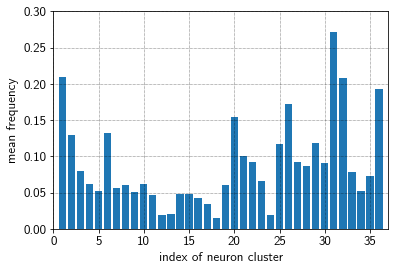

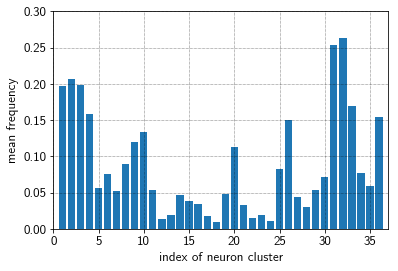

In [18]:
binSize = 10
numclusters = int(exp.p.reservoirExSize / np.square(binSize))

# Get binned spikes
slmb = getClusteredFrequencies(np.mean(sl, axis=1), binSize)
snmb = getClusteredFrequencies(np.mean(sn, axis=1), binSize)

# Plot Loihi
plt.bar(1+np.arange(numclusters), slmb)
#plt.title('Loihi')
plt.xlabel('index of neuron cluster')
plt.ylabel('mean frequency')
plt.xlim((0,numclusters+1))
plt.ylim((0,0.3))
plt.savefig(exp.net.plot.plotDir + 'frequency_loihi.svg')
p = plt.show()

# Plot Nest
plt.bar(1+np.arange(numclusters), snmb)
#plt.title('Nest')
plt.xlabel('index of neuron cluster')
plt.ylabel('mean frequency')
plt.xlim((0,numclusters+1))
plt.ylim((0,0.3))
plt.savefig(exp.net.plot.plotDir + 'frequency_nest.svg')
p = plt.show()

In [24]:
ks = scipy.stats.ks_2samp(slmb/np.sum(slmb), snmb/np.sum(snmb))
ks

Ks_2sampResult(statistic=0.16666666666666669, pvalue=0.6584781905494747)

In [20]:
topl = np.array([binl[:,i:i+60] for i in range(0,3600,60)])
topl = np.moveaxis(topl,1,0)

topn = np.array([binn[:,i:i+60] for i in range(0,3600,60)])
topn = np.moveaxis(topn,1,0)

NameError: name 'binl' is not defined

In [ ]:
#topl = np.array([sl[i:i+60,:] for i in range(0,3600,60)])
#topl = np.moveaxis(topl,1,0)

#topn = np.array([sn[i:i+60,:] for i in range(0,3600,60)])
#topn = np.moveaxis(topn,1,0)

In [ ]:
topl.shape

In [ ]:
topl[topl>0.2] = 1
topl[topl<=0.2] = 0

In [ ]:
%matplotlib inline
cmap = colors.ListedColormap(['white', 'darkred'])
p = plt.imshow(topl[:,:,0], cmap=cmap)

In [ ]:
topn[topn>0.2] = 1
topn[topn<=0.2] = 0

In [ ]:
%matplotlib inline
cmap = colors.ListedColormap(['white', 'darkred'])
p = plt.imshow(topn[:,:,0], cmap=cmap)

%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(4,4))

#cmap = colors.ListedColormap(['white', 'darkred'])

frames = []
for i in range(topl.shape[0]):
    frames.append([plt.imshow(topl[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
ani.save('loihi.mp4')
plt.show()

%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(4,4))

#cmap = colors.ListedColormap(['white', 'darkred'])

frames = []
for i in range(topn.shape[0]):
    frames.append([plt.imshow(topn[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
ani.save('nest.mp4')
plt.show()